In [1]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import mdtraj as md
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor


In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")


In [3]:
def read_cs_md(data):
    confd = {'HA': {},
             'CA': {},
             'CB': {},
             'C': {},
             'H': {},
             'HA2': {},
             'HA3': {},
             'N': {}}
    for lines in open(data, "r").readlines():
        riga = lines.strip().split(",")
        # key dictionary
        key = riga[0]
        key2 = riga[1]
        confd[key2][key] = []
        timeseries = np.asarray(riga[2:-1]).astype(float)
        confd[key2][key] = timeseries
    return(confd)


def read_exp_cs(data):
    confd = {'HA': {},
             'CA': {},
             'CB': {},
             'C': {},
             'H': {},
             'HA2': {},
             'HA3': {},
             'N': {}}
    for lines in open(data, "r").readlines():
        riga = lines.strip().split("\t")
        # key dictionary
        key = riga[0]
        key2 = riga[1]
        confd[key2][key] = []
        confd[key2][key] += map(float, [float(riga[2])])
    return(confd)


def add_md_data(data, dict, key):
    dict[key] = {}
    for lines in open(data, "r").readlines():
        riga = lines.strip().split(",")
        key2 = riga[0]
        timeseries = np.asarray(riga[1:-1]).astype(float)
        dict[key][key2] = []
        dict[key][key2] = (timeseries)
    return(dict)


def add_exp_data(data, dict, key):
    dict[key] = {}
    for lines in open(data, "r").readlines():
        riga = lines.strip().split(" ")
        key2 = riga[0]
        dict[key][key2] = []
        dict[key][key2] += map(float, [float(riga[1])])
    return(dict)


def add_md_scalar(data, dict, key):
    dict[key] = {}
    dict[key][0] = np.loadtxt(data)
    return(dict)


def add_md_scalar_skip0(data, dict, key):
    dict[key] = {}
    dict[key][0] = np.loadtxt(data)[0:-1]
    return(dict)


def add_exp_scalar(data, dict, key):
    dict[key] = {}
    dict[key][0] = [data]
    return(dict)


In [4]:
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])
    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]
    # we need a list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])
    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")
    return (s[k]/2**(d-k))


In [5]:
outdir = '/home/jaya/work/sparta_data/p53/apo/out_data_daisy/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
log = open(outdir+"/log", "w")

pdb = '/home/jaya/work/analysis_trajectories/p53/rest/xtc_apo/prot.pdb'
rep0 = '/home/jaya/work/analysis_trajectories/p53/rest/xtc_apo/rep/pbc_0.xtc'
helixpdb = '/home/jaya/work/analysis_trajectories/p53/p53_sa.pdb'

print("outdir:", outdir)
print("pdb:", pdb)
print("trjaectory:", rep0)

trj = md.load(rep0, top=pdb, stride=20)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames


outdir: /home/jaya/work/sparta_data/p53/apo/out_data_daisy/
pdb: /home/jaya/work/analysis_trajectories/p53/rest/xtc_apo/prot.pdb
trjaectory: /home/jaya/work/analysis_trajectories/p53/rest/xtc_apo/rep/pbc_0.xtc


In [6]:
print("Trajectory", rep0)
print("PDB:", pdb)
helix = md.load_pdb(helixpdb)
top_helix = helix.topology
backbone_helix = top_helix.select("backbone")
backbone = top_helix.select("backbone")

# [0:-1] is to match trajectory to reweight data
trj = md.load(rep0, top=pdb, stride=1)[0:-1]
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames

nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
log.write("** SYSTEM INFO **\n")
log.write("Structure filename: %s\n" % pdb)
log.write("Trajectory filenames: %s\n" % rep0)
log.write("Number of atoms: %d\n" % trj.n_atoms)
log.write("Number of residues: %d\n" % len(set(nres)))
log.write("Number of frames: %d\n" % trj.n_frames)

print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

residues = 61
residue_offset = 0
residue_number = range(residue_offset, residue_offset+residues)
resnum = np.arange(0, residue_offset+residues+1, 1)

# Calculate Rg
mass = []
for at in trj.topology.atoms:
    mass.append(at.element.mass)
mass_CA = len(mass)*[0.0]
for i in trj.topology.select("name CA"):
    mass_CA[i] = 1.0
rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
SE_rg = (block(rg_CA))**.5
np.savetxt(outdir+"/Rgyr-CA.dat", rg_CA, header="Rgyr-CA", fmt='%.4lf')
np.savetxt(outdir+"/Rgyr-CA.ave.dat",
           np.column_stack([np.average(rg_CA), SE_rg]),  fmt='%.4lf')


Trajectory /home/jaya/work/analysis_trajectories/p53/rest/xtc_apo/rep/pbc_0.xtc
PDB: /home/jaya/work/analysis_trajectories/p53/rest/xtc_apo/prot.pdb
** SYSTEM INFO **

Number of atoms: 926

Number of residues: 61

Number of protein residues: 61

Number of frames: 25155

Starting frame: 0

Last frame: 25155

sequence:  [MET1, GLU2, GLU3, PRO4, GLN5, SER6, ASP7, PRO8, SER9, VAL10, GLU11, PRO12, PRO13, LEU14, SER15, GLN16, GLU17, THR18, PHE19, SER20, ASP21, LEU22, TRP23, LYS24, LEU25, LEU26, PRO27, GLU28, ASN29, ASN30, VAL31, LEU32, SER33, PRO34, LEU35, PRO36, SER37, GLN38, ALA39, MET40, ASP41, ASP42, LEU43, MET44, LEU45, SER46, PRO47, ASP48, ASP49, ILE50, GLU51, GLN52, TRP53, PHE54, THR55, GLU56, ASP57, PRO58, GLY59, PRO60, ASP61]

residue names:  ['MET', 'GLU', 'GLU', 'PRO', 'GLN', 'SER', 'ASP', 'PRO', 'SER', 'VAL', 'GLU', 'PRO', 'PRO', 'LEU', 'SER', 'GLN', 'GLU', 'THR', 'PHE', 'SER', 'ASP', 'LEU', 'TRP', 'LYS', 'LEU', 'LEU', 'PRO', 'GLU', 'ASN', 'ASN', 'VAL', 'LEU', 'SER', 'PRO', 'LEU'

In [7]:
expdata = read_exp_cs('/home/jaya/work/sparta_data/p53/apo/cs_exp_input.dat')
compdata = read_cs_md('/home/jaya/work/sparta_data/p53/apo/cs_assignment.csv')

reweight_data_frames = len(compdata['CA']['2'])
print("Reweight Data Frames:", reweight_data_frames)


Reweight Data Frames: 25155


In [8]:
# Set Data For Reweighting and Validation
Reweight_Data = ['CA']
Validation_Data = ['CA', 'CB', 'H', 'N', 'C']
# STRENGTH OF THE RESTRAINT
sigma_m = float(15.0)

# Validation_Data=['HA','CA','CB','H','N']
# Reweight_Data=['RDC','JHNHA']
compare = []
exp_r = []
traj_r = []
err_r = []
data_r_t = []
data_r_type = {}

traj_v = []
exp_v = []
data_v_t = []
data_v_type = {}
err_v = []

# PREFACTORS FOR ERROR ESTIMATES FOR EACH EXPERIMENTAL DATA
err_d = {'HA': 0.1,
         'CA': 0.2,
         'CB': 0.2,
         'C':  0.2,
         'H':  0.1,
         'HA2': 0.1,
         'HA3': 0.1,
         'N': 0.5,
         'RDC': 0.5,
         'Rg': 0.01,
         'JHNHA': 0.25}

# For Debugging
compare_dict_r = {'HA': {},
                  'CA': {},
                  'CB': {},
                  'C': {},
                  'H': {},
                  'HA2': {},
                  'HA3': {},
                  'N': {},
                  'RDC': {},
                  'Rg': {},
                  'JHNHA': {}}

# Also For Debugging
compare_dict_v = {'HA': {},
                  'CA': {},
                  'CB': {},
                  'C': {},
                  'H': {},
                  'HA2': {},
                  'HA3': {},
                  'N': {},
                  'RDC': {},
                  'JHNHA': {},
                  'Rg': {}}


# Process Reweight data into arrays
for key in Reweight_Data:
    for key2 in expdata[key]:
        # Check if Experimental Value is 0, if not retrieve the MD timeseries
        if expdata[key][key2][0] != 0:
            if key2 in compdata[key]:
                if compdata[key][key2][0] != 0:
                    compare_dict_r[key][key2] = (
                        [expdata[key][key2][0], compdata[key][key2]])
                    traj_r.append(compdata[key][key2])
                    exp_r.append(expdata[key][key2][0])
                    err_r.append(err_d[key])
                    data_r_t.append(str(key))

for key in Reweight_Data:
    data_id = np.zeros(len(data_r_t))
    for i, id in enumerate(data_r_t):
        if id == str(key):
            data_id[i] = float(1)
    data_r_type[key] = data_id

# Process Validation data into arrays
for key in Validation_Data:
    for key2 in expdata[key]:
        if expdata[key][key2][0] != 0:
            if key2 in compdata[key]:
                if compdata[key][key2][0] != 0:
                    # This is a hack so it doesn't choke for non-residue specific data read in as an array
                    # if np.average(compdata[key][key2][0])!=0:
                    compare_dict_v[key][key2] = (
                        [expdata[key][key2][0], compdata[key][key2]])
                    traj_v.append(compdata[key][key2])
                    exp_v.append(expdata[key][key2][0])
                    err_v.append(err_d[key])
                    data_v_t.append(str(key))

for key in Validation_Data:
    data_id = np.zeros(len(data_v_t))
    for i, id in enumerate(data_v_t):
        if id == str(key):
            data_id[i] = float(1)
    data_v_type[key] = data_id


In [9]:
# data for reweighting - 1 column per exp data - 1 row per MD frame
traj_r = np.asarray(traj_r)
traj_v = np.asarray(traj_v)
# experimental data for reweighting - 1 column per exp data - 1 row
obs_exp_r = np.asarray(exp_r)
obs_exp_v = np.asarray(exp_v)
# predictor/experimental errors for reweighting - 1 column per exp data - 1 row
err_r = np.asarray(err_r)
err_v = np.asarray(err_v)

# Uniform Initial Weights For Each Frame
weight_bias = np.ones(len(traj_r[0]))
# sigma_m=float(0.1)
# calculate sigma vector
sigma = sigma_m*err_r
# number of observables
nobs_r = len(sigma)
nobs_v = len(obs_exp_v)
# number of frames
nframes = len(traj_r[0])

print('# of Frames:', nframes)
log.write('# of Frames:%s' % nframes+"\n")

print('Reweight Data Points:', nobs_r)
log.write('Reweight Data Points: %s' % nobs_r+"\n")

for key in data_r_type:
    print(str(key)+':', sum(data_r_type[key]))
    log.write(str(key)+': %s' % sum(data_r_type[key])+"\n")

print('Validation Data Points:', nobs_v)
log.write('Validation Data Points: %s' % nobs_v+"\n")
for key in data_v_type:
    print(str(key)+':', sum(data_v_type[key]))
    log.write(str(key)+': %s' % sum(data_v_type[key])+"\n")


# of Frames: 25155
Reweight Data Points: 60
CA: 60.0
Validation Data Points: 278
CA: 60.0
CB: 59.0
H: 50.0
N: 50.0
C: 59.0


In [10]:
# maxent calculation

# function to be minimized:
# attention: it reads global variables weight_bias, obs_exp, and sigma
def func(l):
    l = np.array(l)  # ensure array
    weight_all = +weight_bias  # copy
    weight_all -= np.dot(l, traj_r)  # maxent correction
    shift_all = np.max(weight_all)  # shift to avoid overflow
    weight_all = np.exp(weight_all - shift_all)  # compute weights

    # same stuff with original ensemble
    weight_0 = +weight_bias  # copy
    shift_0 = np.max(weight_0)  # shift to avoid overflow
    weight_0 = np.exp(weight_0 - shift_0)  # compute weights

    # Gamma function in maxent:
    # Shifts to avoid overflows
    f = np.log(np.sum(weight_all) / np.sum(weight_0)) + \
        shift_all - shift_0 + np.dot(l, obs_exp_r)

    # derivative of Gamma function:
    der = obs_exp_r - np.dot(traj_r, weight_all) / \
        np.sum(weight_all)  # derivative with respect to l

    # regularization term
    # REGULARIZE
    f += 0.5*np.sum(sigma*l**2)
    der += sigma*l

    return(f, der)


In [11]:
# perform minimization
# res.X lagrange multiplier
res = sp.optimize.minimize(func, np.zeros(
    (nobs_r,)), method='L-BFGS-B', jac=True)


# ANALYSIS
# calculate normalized initial weights
initial_weights = weight_bias
initial_weights -= np.max(initial_weights)
initial_weights = np.exp(initial_weights)
initial_weights /= np.sum(initial_weights)
# initial average observables for reweighting and validation
initial_obs_r = np.dot(traj_r, initial_weights)
initial_obs_v = np.dot(traj_v, initial_weights)

# various initial RMSE
print("Initial RMSE reweight data ")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end='')
    print("     %6.3lf" % np.sqrt(
        np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t) == 'RDC':
        qi, rms_i, qf, rms_f, rdc_scale_i = scale_rdc_Q(
            initial_obs_r*data_r_type['RDC'], obs_exp_r*data_r_type['RDC'])
        print(" *    RDC scaled Q:", end='')
        print(" %6.3lf" % qf)

print("Initial RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end='')
    # (initial_obs_v-obs_exp_v)**2*data_v_type[t])
    print("     %6.3lf" % np.sqrt(
        np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t) == 'RDC':
        qi, rms_i, qf, rms_f, rdc_scale_i = scale_rdc_Q(
            initial_obs_v*data_v_type['RDC'], obs_exp_v*data_v_type['RDC'])
        print(" *    RDC scaled Q:", end='')
        print(" %6.3lf" % qf)

print("minimization worked:", res.success)
#print("lagrangian multipliers:",res.x)
# calculate normalized final weights
final_weights = (weight_bias-np.dot(res.x, traj_r))
final_weights -= np.max(final_weights)
final_weights = np.exp(final_weights)
final_weights /= np.sum(final_weights)
# final average observables for reweighting and validation
final_obs_r = np.dot(traj_r, final_weights)
final_obs_v = np.dot(traj_v, final_weights)
# various final RMSE
print("Final RMSE reweight data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end='')
    print("     %6.3lf" % np.sqrt(
        np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t) == 'RDC':
        qi, rms_i, qf, rms_f, rdcs_scale_f = scale_rdc_Q(
            final_obs_r*data_r_type['RDC'], obs_exp_r*data_r_type['RDC'])
        print(" *    RDC Q_scaled:", end='')
        print(" %6.3lf" % qf)

print("Final RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end='')
    print("     %6.3lf" % np.sqrt(
        np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t) == 'RDC':
        qi, rms_i, qf, rms_f, rdc_scale_f = scale_rdc_Q(
            final_obs_v*data_v_type['RDC'], obs_exp_v*data_v_type['RDC'])
        print(" *    RDC Q_scaled:", end='')
        print(" %6.3lf" % qf)


# Kish effective size
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
print("Kish ratio : %9.6lf" % (Ks_a/Ks_b*100.0))

# print final weights to file
f = open("test_w_final-"+str(sigma_m)+".dat", "w")
for w in final_weights:
    f.write("%e\n" % w)
f.close()


Initial RMSE reweight data 
 * Total :      0.430
 *    CA :      0.430
Initial RMSE validation data
 * Total :      0.434
 *    CA :      0.430
 *    CB :      0.292
 *     H :      0.153
 *     N :      0.704
 *     C :      0.420
minimization worked: True
Final RMSE reweight data
 * Total :      0.310
 *    CA :      0.310
Final RMSE validation data
 * Total :      0.377
 *    CA :      0.310
 *    CB :      0.266
 *     H :      0.145
 *     N :      0.630
 *     C :      0.381
Initial Kish size :  1.000000 25154
Reweighted Kish size :  0.560576 14101
Kish ratio : 56.057616


CA
RMSD_initial: 0.430 RMSD_final: 0.310
r2 initial: 0.986 r2 final: 0.993


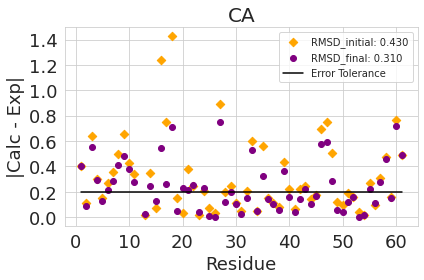

CB
RMSD_initial: 0.292 RMSD_final: 0.266
r2 initial: 0.999 r2 final: 0.999


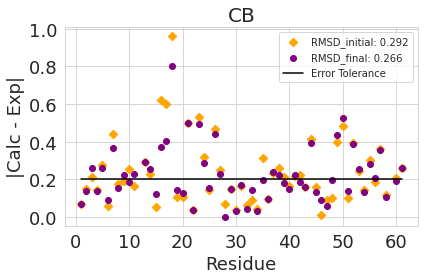

H
RMSD_initial: 0.153 RMSD_final: 0.145
r2 initial: 0.521 r2 final: 0.548


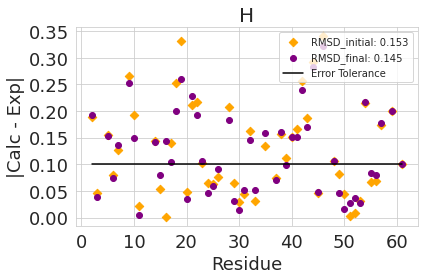

N
RMSD_initial: 0.704 RMSD_final: 0.630
r2 initial: 0.942 r2 final: 0.953


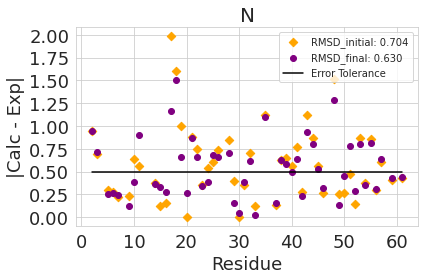

C
RMSD_initial: 0.420 RMSD_final: 0.381
r2 initial: 0.842 r2 final: 0.870


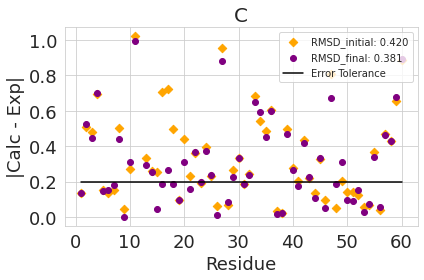

In [12]:
import sklearn
from sklearn.metrics import r2_score

for t in Validation_Data:
    if t != 'Rg':
        print(t)
        resid = []
        exp = []
        calc = []
        err_fit = []
        err = err_d[t]
        for i, id in enumerate(compare_dict_v[t]):
            resid.append(float(id))
            exp.append(compare_dict_v[t][id][0])
            err_fit.append(err)
        initial = np.trim_zeros(initial_obs_v*data_v_type[t])
        reweight = np.trim_zeros(final_obs_v*data_v_type[t])
        exp = np.trim_zeros(obs_exp_v*data_v_type[t])
        err = err_d[t]
        rmsd_i = (sum(np.square(initial-exp))/len(exp))**0.5
        rmsd_f = (sum(np.square(reweight-exp))/len(exp))**0.5
        r2_i = r2_score(initial, exp)
        r2_f = r2_score(reweight, exp)
        print("RMSD_initial:%6.3lf" % (sum(np.square(initial-exp))/len(exp)) **
              0.5, "RMSD_final:%6.3lf" % (sum(np.square(reweight-exp))/len(exp))**0.5)
        print("r2 initial:%6.3lf" % r2_i, "r2 final:%6.3lf" % r2_f)
        plt.clf()
        plt.scatter(np.asarray(resid), np.absolute(
            initial-exp), color='orange', marker='D', label="RMSD_initial:%6.3lf" % rmsd_i)
        plt.scatter(np.asarray(resid), np.absolute(reweight-exp),
                    color='purple', label="RMSD_final:%6.3lf" % rmsd_f)
        plt.plot(np.asarray(resid), err_fit,
                 color='black', label='Error Tolerance')
        plt.ylabel('|Calc - Exp|', size=18)
        plt.title('%s' % t, size='20')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xticks(size='18')
        plt.yticks(size='18')
        plt.xlabel('Residue', size=18)
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()


H
RMSD_initial: 0.153 RMSD_final: 0.145
r2 initial: 0.534 r2 final: 0.582


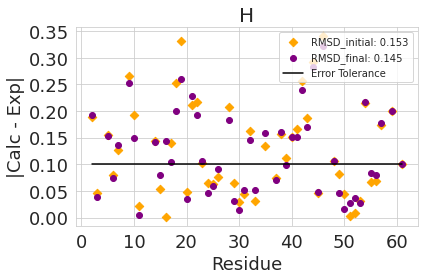

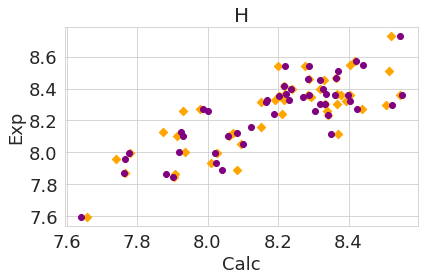

Data Mean: 8.24702
Initial Correlation Coefficient: 0.5344874987621351
Reweight Correlation Coefficient: 0.5821374138020703


In [13]:
H_Data = Validation_Data = ['H']
for t in Validation_Data:
    if t != 'Rg':
        print(t)
        resid = []
        exp = []
        calc = []
        err_fit = []
        err = err_d[t]
        for i, id in enumerate(compare_dict_v[t]):
            resid.append(float(id))
            exp.append(compare_dict_v[t][id][0])
            err_fit.append(err)
        initial = np.trim_zeros(initial_obs_v*data_v_type[t])
        reweight = np.trim_zeros(final_obs_v*data_v_type[t])
        exp = np.trim_zeros(obs_exp_v*data_v_type[t])
        err = err_d[t]
        rmsd_i = (sum(np.square(initial-exp))/len(exp))**0.5
        rmsd_f = (sum(np.square(reweight-exp))/len(exp))**0.5
        r2_i = r2_score(exp, initial)
        r2_f = r2_score(exp, reweight)
        print("RMSD_initial:%6.3lf" % (sum(np.square(initial-exp))/len(exp)) **
              0.5, "RMSD_final:%6.3lf" % (sum(np.square(reweight-exp))/len(exp))**0.5)
        print("r2 initial:%6.3lf" % r2_i, "r2 final:%6.3lf" % r2_f)
        plt.clf()
        plt.scatter(np.asarray(resid), np.absolute(
            initial-exp), color='orange', marker='D', label="RMSD_initial:%6.3lf" % rmsd_i)
        plt.scatter(np.asarray(resid), np.absolute(reweight-exp),
                    color='purple', label="RMSD_final:%6.3lf" % rmsd_f)
        plt.plot(np.asarray(resid), err_fit,
                 color='black', label='Error Tolerance')
        plt.ylabel('|Calc - Exp|', size=18)
        plt.title('%s' % t, size='20')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xticks(size='18')
        plt.yticks(size='18')
        plt.xlabel('Residue', size=18)
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

plt.clf()
plt.scatter(initial, exp, color='orange', marker='D',
            label="RMSD_initial:%6.3lf" % rmsd_i)
plt.scatter(reweight, exp, color='purple', label="RMSD_final:%6.3lf" % rmsd_f)
plt.ylabel('Exp', size=18)
plt.title('%s' % t, size='20')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='18')
plt.yticks(size='18')
plt.xlabel('Calc', size=18)
plt.tight_layout()
plt.show()


# Calculate the mean
exp_data = exp
exp_mean = np.mean(exp_data)
print("Data Mean:", exp_mean)
# Subtract the mean value from every data point in y
exp_deviation = exp_data-exp_mean
# Now we square these deviations:
exp_deviation_squared = exp_deviation**2

# Now we take the sum of the deviations squared:
# "Total Sum of Squares":  SStot=Summation((y_i-y_ave)^2) for each element i in our dataset
SStot = np.sum(exp_deviation_squared)

# We generate the y_values predicted by our model:
calc_data = initial
# Now we calculate the sum of the squares of the residuals from out linear fit
# "Residual Sum of Squares": SS_residuals=Summation((y_pred_i-y_i)^2) for each element i in our dataset
SS_residuals = np.sum((calc_data-exp_data)**2)
# R^2 = 1 - SS_residuels/SS_total
R2 = 1-SS_residuals/SStot
print("Initial Correlation Coefficient:", R2)

calc_data = reweight
# Now we calculate the sum of the squares of the residuals from out linear fit
# "Residual Sum of Squares": SS_residuals=Summation((y_pred_i-y_i)^2) for each element i in our dataset
SS_residuals = np.sum((calc_data-exp_data)**2)
# R^2 = 1 - SS_residuels/SS_total
R2 = 1-SS_residuals/SStot
print("Reweight Correlation Coefficient:", R2)


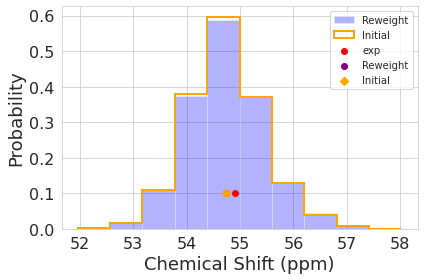

<Figure size 432x288 with 0 Axes>

In [14]:
# expdata['CA']
# The 45/436 is vp=43
# expdata['CA']['43']

vp = 43
plt.hist(traj_r[vp], weights=final_weights, density='true',
         alpha=0.3, label='Reweight', color='blue')
plt.hist(traj_r[vp], density='true', linewidth=2,
         color='orange', histtype='step', label='Initial')
plt.scatter(obs_exp_r[vp], 0.1, color='red', label='exp')
plt.scatter(final_obs_r[vp], 0.1, color='purple', label='Reweight')
plt.scatter(initial_obs_r[vp], 0.1, color='orange',
            marker='D', label='Initial')
#plt.ylim(0, 0.3)
plt.xlabel('Chemical Shift (ppm)', size=18)
plt.ylabel('Probability', size=18)
plt.legend(loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='16')
plt.yticks(size='16')
plt.tight_layout()
plt.savefig('%s/Example.vp.%s.png' % (outdir, vp))
plt.show()
plt.clf()


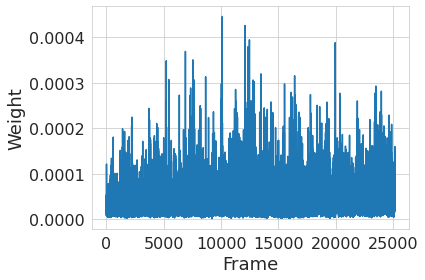

<Figure size 432x288 with 0 Axes>

In [15]:
# Compare Weights
# All_weights=final_weights
plt.plot(final_weights)
plt.ylabel('Weight', size=18)
plt.xlabel('Frame', size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='16')
plt.yticks(size='16')
plt.tight_layout()
plt.savefig('%s/FrameWeights.png' % outdir)
plt.show()
plt.clf()


CA
RMSD_initial: 0.430 RMSD_final: 0.310


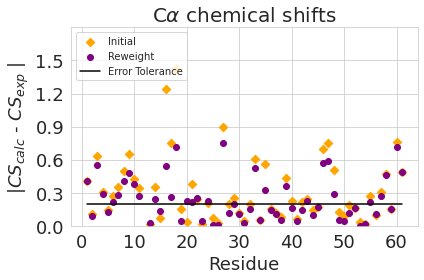

<Figure size 432x288 with 0 Axes>

In [16]:
# Plot Fitting Data

t = 'CA'
# for t in data_r_type:
print(t)
resid = []
exp = []
calc = []
err_fit = []
err = err_d[t]
for i, id in enumerate(compare_dict_r[t]):
    resid.append(float(id))
    exp.append(compare_dict_r[t][id][0])
    err_fit.append(err)
initial = np.trim_zeros(initial_obs_r*data_r_type[t])
reweight = np.trim_zeros(final_obs_r*data_r_type[t])
exp = np.trim_zeros(obs_exp_r*data_r_type[t])
err = err_d[t]
print("RMSD_initial:%6.3lf" % (sum(np.square(initial-exp))/len(exp))**0.5,
      "RMSD_final:%6.3lf" % (sum(np.square(reweight-exp))/len(exp))**0.5)
if t == 'RDC':
    qi_i, rms_i_i, qf_i, rms_f_i, i_fit = scale_rdc_Q(exp, initial)
    qi_f, rms_f_f, qf_f, rms_f_f, f_fit = scale_rdc_Q(exp, reweight)
    print("Q_inital:, RMS_initial, Q_reweight, RMS_reweight")


plt.scatter(np.asarray(resid)+residue_offset, np.absolute(initial -
            exp), color='orange', marker='D', label='Initial')
plt.scatter(np.asarray(resid)+residue_offset,
            np.absolute(reweight-exp), color='purple', label='Reweight')
plt.plot(np.asarray(resid)+residue_offset, err_fit,
         color='black', label='Error Tolerance')
plt.ylim(0, 1.8)
plt.yticks(np.arange(0, 1.8, 0.3))
plt.ylabel(r'|$CS_{calc}$ - $CS_{exp}$ |', size=18)
plt.title(r'C$\alpha$ chemical shifts', size='20')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='18')
plt.yticks(size='18')
plt.xlabel('Residue', size=18)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('%s/CA.reweight.png' % outdir)
plt.show()
plt.clf()


CB
RMSD_initial: 0.292 RMSD_final: 0.266


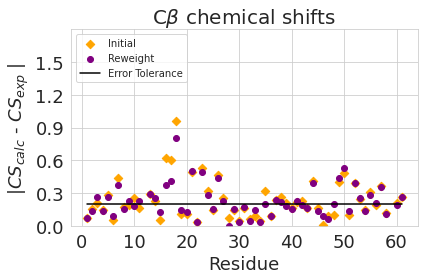

<Figure size 432x288 with 0 Axes>

In [17]:
# Plot Validation Data

t = 'CB'
# for t in data_r_type:
print(t)
resid = []
exp = []
calc = []
err_fit = []
err = err_d[t]
for i, id in enumerate(compare_dict_v[t]):
    resid.append(float(id))
    exp.append(compare_dict_v[t][id][0])
    err_fit.append(err)
initial = np.trim_zeros(initial_obs_v*data_v_type[t])
reweight = np.trim_zeros(final_obs_v*data_v_type[t])
exp = np.trim_zeros(obs_exp_v*data_v_type[t])
print("RMSD_initial:%6.3lf" % (sum(np.square(initial-exp))/len(exp))**0.5,
      "RMSD_final:%6.3lf" % (sum(np.square(reweight-exp))/len(exp))**0.5)
if t == 'RDC':
    qi_i, rms_i_i, qf_i, rms_f_i, i_fit = scale_rdc_Q(exp, initial)
    qi_f, rms_f_f, qf_f, rms_f_f, f_fit = scale_rdc_Q(exp, reweight)
    print("Q_inital:, RMS_initial, Q_reweight, RMS_reweight")
    print("%6.3lf %6.3lf %6.3lf %6.3lf" % (qf_i, rms_f_i, qf_f, rms_f_f))
err = err_d[t]
plt.scatter(np.asarray(resid)+residue_offset, np.absolute(initial -
            exp), color='orange', marker='D', label='Initial')
plt.scatter(np.asarray(resid)+residue_offset,
            np.absolute(reweight-exp), color='purple', label='Reweight')
plt.plot(np.asarray(resid)+residue_offset, err_fit,
         color='black', label='Error Tolerance')
plt.ylim(0, 1.8)
plt.yticks(np.arange(0, 1.8, 0.3))
plt.ylabel(r'|$CS_{calc}$ - $CS_{exp}$ |', size=18)
plt.title(r'C$\beta$ chemical shifts', size='20')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='18')
plt.yticks(size='18')
plt.xlabel('Residue', size=18)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('%s/CB.reweight.png' % outdir)
plt.show()
plt.clf()


N
RMSD_initial: 0.704 RMSD_final: 0.630


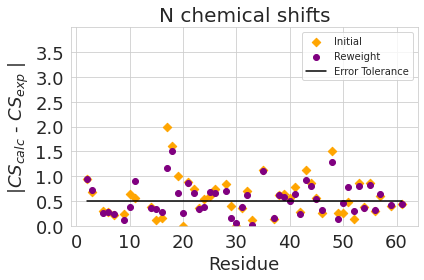

<Figure size 432x288 with 0 Axes>

In [18]:
t = 'N'
# for t in data_r_type:
print(t)
resid = []
exp = []
calc = []
err_fit = []
err = err_d[t]
for i, id in enumerate(compare_dict_v[t]):
    resid.append(float(id))
    exp.append(compare_dict_v[t][id][0])
    err_fit.append(err)
initial = np.trim_zeros(initial_obs_v*data_v_type[t])
reweight = np.trim_zeros(final_obs_v*data_v_type[t])
exp = np.trim_zeros(obs_exp_v*data_v_type[t])
print("RMSD_initial:%6.3lf" % (sum(np.square(initial-exp))/len(exp))**0.5,
      "RMSD_final:%6.3lf" % (sum(np.square(reweight-exp))/len(exp))**0.5)
if t == 'RDC':
    qi_i, rms_i_i, qf_i, rms_f_i, i_fit = scale_rdc_Q(exp, initial)
    qi_f, rms_f_f, qf_f, rms_f_f, f_fit = scale_rdc_Q(exp, reweight)
    print("Q_inital:, RMS_initial, Q_reweight, RMS_reweight")
    print("%6.3lf %6.3lf %6.3lf %6.3lf" % (qf_i, rms_f_i, qf_f, rms_f_f))
err = err_d[t]
plt.scatter(np.asarray(resid)+residue_offset, np.absolute(initial -
            exp), color='orange', marker='D', label='Initial')
plt.scatter(np.asarray(resid)+residue_offset,
            np.absolute(reweight-exp), color='purple', label='Reweight')
plt.plot(np.asarray(resid)+residue_offset, err_fit,
         color='black', label='Error Tolerance')
plt.ylim(0, 4.0)
plt.yticks(np.arange(0, 4.0, 0.5))
plt.ylabel(r'|$CS_{calc}$ - $CS_{exp}$ |', size=18)
plt.title(r'N chemical shifts', size='20')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='18')
plt.yticks(size='18')
plt.xlabel('Residue', size=18)
plt.legend()
plt.tight_layout()
plt.savefig('%s/N.reweight.png' % outdir)
plt.show()
plt.clf()


C
RMSD_initial: 0.420 RMSD_final: 0.381


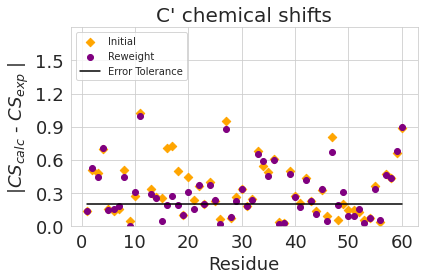

<Figure size 432x288 with 0 Axes>

In [19]:
t = 'C'
# for t in data_r_type:
print(t)
resid = []
exp = []
calc = []
err_fit = []
err = err_d[t]
for i, id in enumerate(compare_dict_v[t]):
    resid.append(float(id))
    exp.append(compare_dict_v[t][id][0])
    err_fit.append(err)
initial = np.trim_zeros(initial_obs_v*data_v_type[t])
reweight = np.trim_zeros(final_obs_v*data_v_type[t])
exp = np.trim_zeros(obs_exp_v*data_v_type[t])
print("RMSD_initial:%6.3lf" % (sum(np.square(initial-exp))/len(exp))**0.5,
      "RMSD_final:%6.3lf" % (sum(np.square(reweight-exp))/len(exp))**0.5)
if t == 'RDC':
    qi_i, rms_i_i, qf_i, rms_f_i, i_fit = scale_rdc_Q(exp, initial)
    qi_f, rms_f_f, qf_f, rms_f_f, f_fit = scale_rdc_Q(exp, reweight)
    print("Q_inital:, RMS_initial, Q_reweight, RMS_reweight")
    print("%6.3lf %6.3lf %6.3lf %6.3lf" % (qf_i, rms_f_i, qf_f, rms_f_f))
err = err_d[t]
plt.scatter(np.asarray(resid)+residue_offset, np.absolute(initial -
            exp), color='orange', marker='D', label='Initial')
plt.scatter(np.asarray(resid)+residue_offset,
            np.absolute(reweight-exp), color='purple', label='Reweight')
plt.plot(np.asarray(resid)+residue_offset, err_fit,
         color='black', label='Error Tolerance')
plt.ylim(0, 1.8)
plt.yticks(np.arange(0, 1.8, 0.3))
plt.ylabel(r'|$CS_{calc}$ - $CS_{exp}$ |', size=18)
plt.title('C\' chemical shifts', size='20')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='18')
plt.yticks(size='18')
plt.xlabel('Residue', size=18)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('%s/C.reweight.png' % outdir)
plt.show()
plt.clf()


In [20]:
def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E, dsspH, dsspE


/tmp/ipykernel_11258/942909033.py:21: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


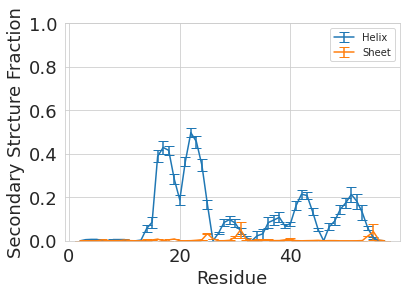

In [21]:
trjH1 = md.load(rep0, top=pdb, stride=1)[0:-1]
H1 = top.select("resid 1 to 56")
trjH1.restrict_atoms(H1)
trjH1.center_coordinates()
frames = trjH1.n_frames

h_res = []
for res in trjH1.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
hres_renum = np.asarray(h_res)+residue_offset


frames = trj.n_frames
half = int(np.floor(frames/2))

dsspH1 = md.compute_dssp(trjH1, simplified=True)

H1_H, H1_E, dsspH, dsspE = dssp_convert(dsspH1)

plt.errorbar(hres_renum, H1_H[:, 0], yerr=H1_H[:, 1], capsize=5, label='Helix')
plt.errorbar(hres_renum, H1_E[:, 0], yerr=H1_E[:, 1], capsize=5, label='Sheet')

plt.ylim(0, 1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt('%s/dssp.H.dat' % outdir, dsspH)
np.savetxt('%s/dssp.E.dat' % outdir, dsspE)
np.savetxt(outdir+'/Hprop.err.dat',
           np.column_stack((hres_renum, H1_H[:, 0], H1_H[:, 1])))
np.savetxt(outdir+'/Eprop.err.dat',
           np.column_stack((hres_renum, H1_E[:, 0], H1_E[:, 1])))


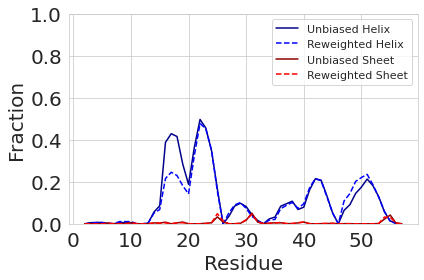

<Figure size 432x288 with 0 Axes>

In [22]:
helix_prop = dsspH
sheet_prop = dsspE
Hprop = np.sum(helix_prop, axis=0).astype(float)/len(helix_prop)
Eprop = np.sum(sheet_prop, axis=0).astype(float)/len(sheet_prop)

reweight_Hprop = []
reweight_Eprop = []
for i in range(0, len(Hprop)):
    reweight_Hprop.append(np.dot(helix_prop[:, i], final_weights))
    reweight_Eprop.append(np.dot(sheet_prop[:, i], final_weights))

plt.plot(hres_renum, Hprop, color='darkblue', label='Unbiased Helix')
plt.ylim(0, 1.0)
plt.plot(hres_renum, reweight_Hprop, color='blue',
         label='Reweighted Helix', linestyle='dashed')
plt.plot(hres_renum, Eprop, color='darkred', label='Unbiased Sheet')
plt.plot(hres_renum, reweight_Eprop, color='red',
         label='Reweighted Sheet', linestyle='dashed')
plt.xlabel('Residue', size=20)
plt.ylabel('Fraction', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
plt.legend(loc='upper right', fontsize=11)

np.savetxt('%s/Hprop.reweight.dat' %
           outdir, np.column_stack((hres_renum, reweight_Hprop)))
np.savetxt('%s/Eprop.reweight.dat' %
           outdir, np.column_stack((hres_renum, reweight_Eprop)))

plt.savefig('%s/SS.reweight.png' % outdir)
plt.show()
plt.clf()


CA
RMSD_initial: 0.430 RMSD_final: 0.310


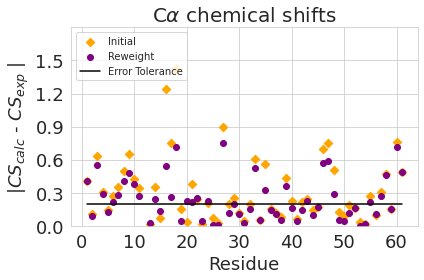

<Figure size 432x288 with 0 Axes>

In [23]:
t = 'CA'
# for t in data_r_type:
print(t)
resid = []
exp = []
calc = []
err_fit = []
err = err_d[t]
for i, id in enumerate(compare_dict_r[t]):
    resid.append(float(id))
    exp.append(compare_dict_r[t][id][0])
    err_fit.append(err)
initial = np.trim_zeros(initial_obs_r*data_r_type[t])
reweight = np.trim_zeros(final_obs_r*data_r_type[t])
exp = np.trim_zeros(obs_exp_r*data_r_type[t])
err = err_d[t]
print("RMSD_initial:%6.3lf" % (sum(np.square(initial-exp))/len(exp))**0.5,
      "RMSD_final:%6.3lf" % (sum(np.square(reweight-exp))/len(exp))**0.5)
if t == 'RDC':
    qi_i, rms_i_i, qf_i, rms_f_i, i_fit = scale_rdc_Q(exp, initial)
    qi_f, rms_f_f, qf_f, rms_f_f, f_fit = scale_rdc_Q(exp, reweight)
    print("Q_inital:, RMS_initial, Q_reweight, RMS_reweight")


plt.scatter(np.asarray(resid)+residue_offset, np.absolute(initial -
            exp), color='orange', marker='D', label='Initial')
plt.scatter(np.asarray(resid)+residue_offset,
            np.absolute(reweight-exp), color='purple', label='Reweight')
plt.plot(np.asarray(resid)+residue_offset, err_fit,
         color='black', label='Error Tolerance')
plt.ylim(0, 1.8)
plt.yticks(np.arange(0, 1.8, 0.3))
plt.ylabel(r'|$CS_{calc}$ - $CS_{exp}$ |', size=18)
plt.title(r'C$\alpha$ chemical shifts', size='20')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='18')
plt.yticks(size='18')
plt.xlabel('Residue', size=18)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('%s/CA.reweight.png' % outdir)
plt.show()
plt.clf()


In [24]:
resid_num = np.asarray(resid)+residue_offset
CA_deviation = np.column_stack((resid_num, initial-exp))
CA_reweight_deviation = np.column_stack((resid_num, reweight-exp))
CAexpVsim = CA_deviation
CAexpVsim

np.savetxt('%s/CA.initialVexp.dat' % outdir, CA_deviation)
np.savetxt('%s/CA.reweightVexp.dat' % outdir, CA_reweight_deviation)


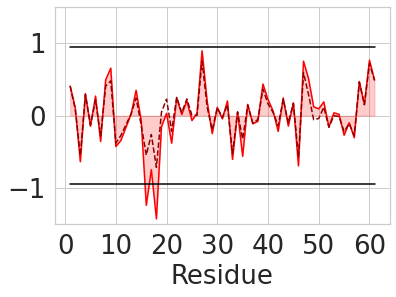

<Figure size 432x288 with 0 Axes>

In [26]:
upper = np.copy(CAexpVsim)
lower = np.copy(CAexpVsim)
zeros = np.copy(CAexpVsim)

for i in range(0, len(upper[:, 0])):
    upper[i, 1] = 0.94
    lower[i, 1] = -0.94
    zeros[i, 1] = 0


sns.set(style='whitegrid')
sns.lineplot(x=CAexpVsim[:, 0], y=-CAexpVsim[:, 1], color='red')
sns.lineplot(x=CA_reweight_deviation[:, 0], y=-
             CA_reweight_deviation[:, 1], color='darkred', linestyle='dashed')
sns.lineplot(x=upper[:, 0], y=upper[:, 1], color='black')
sns.lineplot(x=lower[:, 0], y=lower[:, 1], color='black')
plt.fill_between(CAexpVsim[:, 0], -CAexpVsim[:, 1],
                 zeros[i, 1], color='red', alpha=0.2)
plt.ylim(-1.5, 1.5)
#plt.xlim(390, 446)
plt.xticks(fontsize=26)
plt.yticks([-1.0, 0, 1.0], fontsize=26)
plt.xlabel('Residue', fontsize=26)

plt.grid(True)
plt.savefig(outdir+'/CA.expCS_v_MD.pdf', bbox_inches='tight')
plt.show()
plt.clf()
